<a href="https://colab.research.google.com/github/lw-miles24/CompModNervSys-RCmodel/blob/main/CompModNervSys_exercise4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System
# Exercise 4: Simulating the RC circuit neuron model

### Exercise goals

1) Simulate current stimulation of a passive neuron model using an RC circuit

2) Use numerical integration to simulate a first order differential equation

3) Simulate and understand principles of temporal summation within a single compartment

Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with ***Q:*** preceding them, write your responses in text cells.

# Adding current injection to the RC circuit model

In the last exercise, we started analyzing an RC circuit model the cell membrane. Let's continue by simulating how a neuron responds to subthreshold current injections, which we would do experimentally by inserting an electrode into a neuron connected to a current source.

The figure below shows our RC circuit, with the addition of an intracellular current source. I've also added a figure from Christof Koch's *Biophysics of Computation* that visualizes how we're modeling the entire membrane as a lumped RC circuit.


<img src="https://raw.githubusercontent.com/CompModNervSystem/CompModNervSys-RCmodel/main/resources/RC_current_injection.png" alt_text="RC circuit with current injection" width=250>
<img src="https://raw.githubusercontent.com/CompModNervSystem/CompModNervSys-RCmodel/main/resources/Koch_Fig1.2_RC_model_crop.jpg" alt_text="Illustration of RC model with current injection in spherical cell" width=250>

As you can see, the intracellular domain is treated as isopotential (all at the same voltage). This assumes there's no variation of voltage with space, which makes this a *point* neuron model. Later, we'll use cable theory to simulate how voltages and currents vary in time *and* space within neuron's extended morphologies.

We'll first rederive our equation for membrane voltage with the current source. Using conservation of current (or Kirchoff's current law), we know the current we inject $I(t)$ must equal the membrane current:

$I(t) = I_{m}(t)$.

Here, I included the $t$ to remind us the current injected is a function of time and can vary. By convention, we made the sign of the injected current positive when delivering positive current to the inside of the cell, which we'll see, causes the membrane potential to be increased, or *depolarized*. A negative injected current will make the inside more negative, or *hyperpolarize* the cell.

Recall, the membrane current is the sum of the currents in the two parallel current paths, the capacitive current through $C_{m}$ and ionic current through the membrane resistance $R_{m}$.

$I_{m}(t) = I_{C}(t) + I_{ion}(t)$ (2)

$I(t) = C_{m}\frac{dV_{m}(t)}{dt} + (V_{m}(t) - V_{r})/R_{m}$. (3)

This is essentially the same first order ordinary differential equation with a driving term (the current), instead of the homogeneous form we used last time. You may also notice we renamed the battery term $V_{r}$ to make it more clear we're treating this as the rest potential, which is the equilibrium potential of all the ionic currents.

For now, we'll just deal with the case of constant current injection $I$ at $t=0$. The solution for $V_{m}$ if we choose the initial condition that $V(t=0) = V_{r}$:

$V_{m}(t) = R_{m}I\left( 1 - e^{-\frac{t}{R_{m}C_{m}}}\right) + V_{r}$. (4)

This initial condition should make sense, since this is what we expect the voltage to be at equilibrium in the absence of  current injection (mathematically, equilibrium is when $I_{m} = 0$ and $dV_{m}/dt = 0$). We can also define $V_{ss} = R_{m}I$, or the steady state voltage as $t \rightarrow \infty$.

$V_{m}(t) = V_{ss}\left( 1 - e^{-\frac{t}{R_{m}C_{m}}}\right) + V_{r}$. (5)

Great, we now have an analytical solution for how our simple RC circuit model of a passive neuron responds to constant current injections. Let's simulate the response of a neuron with a membrane resistance $R_{m}$ of 100 $M\Omega$, capacitance $C$ of 100 $pF$, and resting potential $V_{r} = -75 mV$.

<span style="color:red"> ***Q1***: First, what is the value of this neuron's time constant? </span>

The time constant $\tau$ is equal to $Rm * Cm = 10$ ms.

Below, use the equation for $V_{m}(t)$ to simulate the response to a current inputs of -0.1, 0.1, 0.2, and 0.3 $nA$ and plot $V_{m}$ in $mV$ and $t$ in $ms$ using `numpy`/`matplotlib` (or packages of your choosing). To make things easier later, place your equation for $V_{m}$ in a function we'll call `calcRCmemCurrent`. If you use units of $ms$ for time, $M\Omega$ for resistance, $nF$ for capacitance, and $nA$ for current, units will work out to output the membrane voltage in $mV$.

Make sure to choose the length of your time vector to include the dynamics of interest

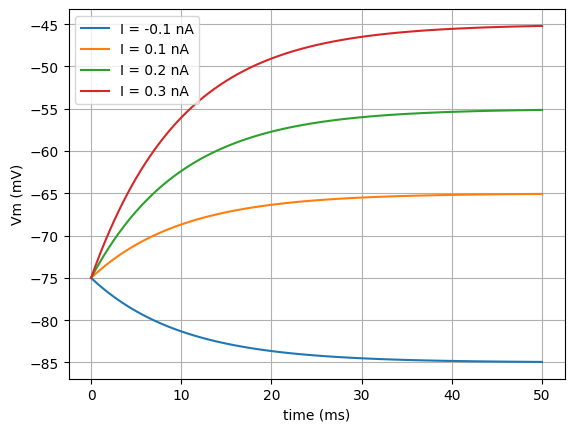

In [ ]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
# Define your function here
def calcRCmemCurrent(t,Rm,Cm,I,Vr):
  # Analytical solution for V(t) given constant current input
  V_ss = Rm * I
  Vm = V_ss * (1 - np.e**(-t / (Rm*Cm))) + Vr
  return Vm

# Define time vector
t = np.linspace(0,50,101) # time in ms
# Define parameters (checking units)
Rm = 100 # MOhm
Cm = 0.1 # nF
Vr = -75 # mV
Is = [-0.1,0.1, 0.2, 0.3] # nA

# Calculate V using equation 5
Vms = []
for I in Is:
    Vms.append(calcRCmemCurrent(t,Rm,Cm,I,Vr))

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
for Vm,I in zip(Vms,Is): # make sure you understand how zip works!
    ax.plot(t,Vm,label='I = {:g} nA'.format(I))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.grid(visible=True)
ax.legend();

<span style="color:red">***Q2***: How might you test/demonstrate that this system is linear with respect to current amplitude? Assume here you're not looking at the equations themselves and only the input/output</span>

In the derivation, we defined the steady-state voltage $Vss$ as directly proportional to $Rm•I$, and $Vm$ is directly proportional to $Vss$. Therefore, if we multiply $I$ by some constant, $Vm$ at equilibrium will be scaled by the same constant.

# Numerical solution of the RC model

Now, let's try simulating the response to different types of current inputs to simulate both different strengths of stimulation (amplitude) and duration. To do this, we'll use a numerical approach. We first go back to the differential form of the equation, which still included the time-varying current input term, equation 3, but rearranged to put the derivative on the left hand side:

$C_{m}\frac{dV_{m}(t)}{dt} =  I(t) - (V_{m}(t) - V_{r})/R_{m}$ . (6)

And divide by $C_{m}$ to get $\frac{dV_{m}(t)}{dt}$ alone:

$\frac{dV_{m}(t)}{dt} =  I(t)/C_{m} - \frac{V_{m}(t) - V_{r}}{R_{m}C_{m}}$ . (7)

We can convert this differential equation to a difference equation by taking the infinitesimally small differential term ($dV/dt$) and imagining instead that we're taking small, finite steps in time (so, $\Delta V_{m}/\Delta t$). Here, $\Delta V_{m} = V_{m}(t + \Delta t) - V_{m}(t)$ and $\Delta t$ is the difference between the current time point and the next time point we're simulating.

$\frac{V_{m}(t + \Delta t) - V_{m}(t)}{\Delta t} =  I(t)/C_{m} - \frac{V_{m}(t) - V_{r}}{R_{m}C_{m}}$ . (8)

We can do some algebra to solve for $V_{m}$ at the next time point ($V_{m}(t+\Delta t)$) in terms of $V_{m}$ at the current time point ($V_{m}(t)$):

$V_{m}(t + \Delta t)=  \Delta t \left( I(t)/C_{m} - \frac{V_{m}(t) - V_{r}}{R_{m}C_{m}} \right)  + V_{m}(t) $. (9)

This is our *update* equation, which allows us to numerically solve the differential equation for any current input. The method we used is known as explicit Euler integration. If you've seen it before, this might be more clear once we recognize the numerator on the right hand side is equal to $\frac{dV_{m}}{dt}$:

$V_{m}(t + \Delta t)=  \Delta t \frac{dV_{m}}{dt} + V_{m}(t) $. (10)

So, in general, if we have a first order differential equation for some variable, a simple approach to solving it (instead of doing any annoying calculus) is to just multiply the derivative at a given time point by the size of the time step we want to take and adding this to whatever the variable is right now. By looping over time, we can simulate how the membrane potential evolves over time for an abitrary current stimulus.

Below, fill in the function `simRCmemCurrentPulse` that implements the explicit Euler method to calculate $V_{m}$ using the equation above.


In [ ]:
def simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur):
    # dt - time step (ms)
    # tstop - simulation duration/last time point (ms)
    # V0 - initial membrane voltage (mV)
    # Rm - membrane resistance (MOhm)
    # Cm - membrane capacitance (nF)
    # Vr - rest potential (mV)
    # I_amp - amplitude of current pulse (nA)
    # I_del - delay of current pulse (nA)
    # I_dur - duration of current pulse (nA)
    t = np.linspace(0,tstop,int((tstop+1)/dt)) # add time vector here
    I = np.zeros(t.shape) # A
    I[np.logical_and(t > I_del, t <= I_del + I_dur)] = I_amp # make sure you understand how this line works
    Vm = np.zeros(t.shape)
    Vm[0] = V0
    for i in range(0,len(t)-1):
      dVm_dt = (I[i] / Cm) - ((Vm[i] - Vr) / (Rm * Cm))
      Vm[i+1] = dt*dVm_dt + Vm[i]
    return Vm,t,I

After running the cell above to instantiate the function, below, simulate the response to a 0.5 nA current pulse that starts at $t = 5 \; ms$ with 10, 20, and 30 ms durations in a neuron with the same parameters as above. Use a $0.1 \; ms$ time step, simulate for $100 \; ms$, and an initial voltage of $V_{r}=-75 \; mV$ again. Plot the responses on the same axes.

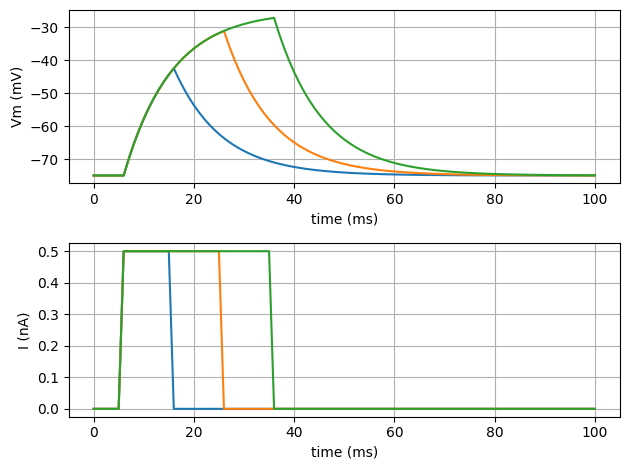

In [ ]:
# Define simulation parameters
dt = 1 # time step (ms)
tstop = 100 # duration of simulation (ms)
V0 = -75 # Initial voltage (mV)

# Define membrane parameters (checking units)
Rm = 100 # Membrane resistance (MOhm)
Cm = 0.1 # Membrane capacitance (nF)
Vr = -75 # Rest potential (mV)

# Define current stimulus
I_amp = 0.5 # nA
I_del = 5 # ms
I_durs = [10,20,30] # ms

# initialize output arrays
Vms = []
ts = []
Is = []
for I_dur in I_durs:
  # Loop through current durations
  # get Vm and I values, append to lists Vms, Is
  Vms.append(simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)[0])
  ts.append(simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)[1])
  Is.append(simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)[2])

# Plot
fig = plt.figure()
ax = fig.add_subplot(211)
for Vm, t in zip(Vms, ts):
  ax.plot(t,Vm)

ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')
ax.grid(visible=True)

ax = fig.add_subplot(212)
for I, t in zip(Is, ts):
  ax.plot(t,I)

ax.set_xlabel('time (ms)')
ax.set_ylabel('I (nA)')
ax.grid(visible=True)

plt.tight_layout(h_pad=1.2)

<span style="color:red"> ***Q3***: What duration of current pulse at this amplitude would be required to reach the steady state voltage (let's say > 99% of steady state)? What steady state value of $V_{m}$ would we expect? (you can add a code block if you want to use code to answer these questions) </span>

In [ ]:
dt = 1 # time step (ms)
tstop = 10000 # duration of simulation (ms)
V0 = -75 # Initial voltage (mV)

# Define membrane parameters (checking units)
Rm = 100 # Membrane resistance (MOhm)
Cm = 0.1 # Membrane capacitance (nF)
Vr = -75 # Rest potential (mV)

# Define current stimulus
I_amp = 0.5 # nA
I_del = 5 # ms
I_durs = I_dur = 10000 # ms

a = simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)[0]
t = simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)[1]

print('steady-state voltage = '+'{:.1f}'.format(a[-1])+' mV') # approximates steady-state

i=0
while i < len(a):
  if a[i] >= V0-0.99*(V0 - a[-1]): # 99% of steady-state
    print('99% of steady state reached at t = '+str(t[i])+' ms') # prints time value at 99%
    i = len(a)
  else:
    i += 1

tstop = 100 # reset this for future code blocks

steady-state voltage = -25.0 mV
99% of steady state reached at t = 50.0 ms


At steady state ($t→\infty$), $Vm$ approaches $-25 mV$, with 99% of that change accomplished in 50 ms.

# Error analysis

It turns out the Explicit Euler method isn't the best way to go when you have more complex differential equations, especially if they exhibit nonlinear behavior, because you need really small time steps to get accurate and stable results. This means it takes longer for the computer to iterate through each step and output an accurate result (higher *computational cost*). Let's check how the accuracy of our solution varies with the size of the time step.

To do this, we first need to choose a simulation case where we have the analytical (exact) solution to compare with our numerical solver. Let's simulate the same neuron with a constant current input of $0.5 \; nA$ for $100 \; ms$. We'll test time steps ranging from $10 \; \mu s$ to $10 ms$.

Second, we need to define some kind of error metric. There are many options, but the one we'll use is the root mean square error, which is just the square root of the mean squared error at all time points, given by

$RMSE = \sqrt(\frac{1}{N}\sum_{i=1}^{N}(x_{i}^{\text{predicted}} - x_{i}^{\text{actual}})^{2}) $,

where $x_{i}^{\text{predicted}}$ and $x_{i}^{\text{actual}}$ are the predicted and actual values of some function $x$ at the $ith$ time point.

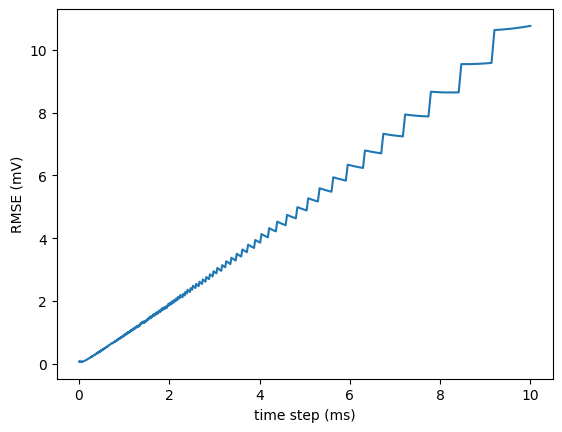

In [ ]:
# Make function to calculate rmse on two equal sized vectors

def rmse(x,y):
    # calculate rmse on two numpy arrays
    # hint: use np.sqrt and np.mean on (x-y)**2
    return np.sqrt(np.mean((x-y)**2))

# Define vector of time steps to test
dt_all = np.logspace(-2,1,1000) # time steps in ms
# Define current stimulus
I_del = 0 # start at t = 0 to match analytical case
I_dur = tstop # apply for full simulation
I_amp = 0.5 # nA
# Loop through all time steps, simulate Vm and compare to analytical solution
# It would be most efficient (less computationally expensive) to just compute the analytical solution once
# But this way we don't have to worry about comparing different length time vectors.
# (It's usually not worth wasting time optimizing code when it already runs this fast)
rmse_all = []
for dt in dt_all:
    # Use simRCmemCurrentPulse and calcRCmemCurrent to generate vectors of the numerical and analytical solution, respectively
    simulated_vec,t,_ = simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)
    analytical_vec = calcRCmemCurrent(t,Rm,Cm,I_amp,Vr)

    # Compute rmse and append to the rmse_all list
    rmse_all.append(rmse(analytical_vec,simulated_vec))

rmse_all = np.array(rmse_all) # convert to numpy array

# Plot RMSE vs. time step
# fig,axes = plt.subplots(2,1,sharex=True)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dt_all,rmse_all)
ax.set_xlabel('time step (ms)')
ax.set_ylabel('RMSE (mV)');
# ax.set_xscale('log')
# ax.set_yscale('log')


<span style="color:red"> ***Q4***: What can you conclude about the relationship between time step and error from this plot for the numerical integration method we're using? </span>

The smaller time step you use, the smaller the error gets, and it looks like this trade-off is basically linear.

Finally, to visualize the effect of time step on the simulated response, plot the voltage in $mV$ vs. time in $ms$  for just 3 of the time steps included above: 0.05, 0.5, and 5 ms, overlaid with the analytical solution. In a second subplot, plot the cumulative absolute error normalized by (divided by) number of time steps vs. time (hint: use `numpy.abs` and `numpy.cumsum`)

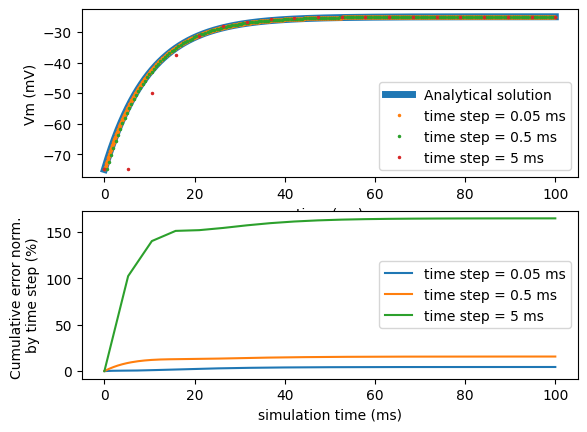

In [ ]:
dt_plot = [0.05,0.5,5] # time steps in ms
# Define current stimulus
I_del = 0 # start at t = 0 to match analytical case
I_dur = tstop # apply for full simulation
I_amp = 0.5 # nA
# Same loop as above, but this time save time and Vm vectors
ts = []
Vm_numerical = []
Vm_analytical = []
# Loop over dt_plot here, append outputs to lists to plot below
for dt in dt_plot:
    # Use simRCmemCurrentPulse and calcRCmemCurrent to generate vectors of the numerical and analytical solution, respectively
    sim_out = np.array(simRCmemCurrentPulse(dt,tstop,V0,Rm,Cm,Vr,I_amp,I_del,I_dur)) # Vm, t, I
    Vm_analytical.append(calcRCmemCurrent(sim_out[1],Rm,Cm,I_amp,Vr))
    Vm_numerical.append(sim_out[0])
    ts.append(sim_out[1])

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(ts[0],Vm_analytical[0],lw=5,label='Analytical solution')
for t,V,dt in zip(ts,Vm_numerical,dt_plot):
    ax.plot(t,V,'.',markersize=3,label='time step = {} ms'.format(dt))
ax.set_ylabel('Vm (mV)')
ax.set_xlabel('time (ms)')

ax.legend()
ax = fig.add_subplot(212)
for t,dt,Vm_num,Vm_an in zip(ts,dt_plot,Vm_numerical,Vm_analytical):
    cumul_error = np.cumsum(np.abs(Vm_num-Vm_an)) * dt
    ax.plot(t,cumul_error,label='time step = {} ms'.format(dt))
ax.set_ylabel('Cumulative error norm. \nby time step (%)')
ax.set_xlabel('simulation time (ms)')

ax.legend();

<span style="color:red"> ***Q5***: Now having visualized the responses and seen how error scales with time step, what would be an appropriate time step for this model? </span>

0.5ms is miles better than 5ms and seems passable, but something around 10 µs might be best if we want to stay under 5% error.

In general there are two strategies to validate the accuracy of a simulation. This is especially important if you're implementing a model using custom code (rather than using existing, pre-validated code):

1) Simulate a special case of the model where we do have the analytical solution (as we did here)

2) Decrease the time step until we find our solution stops changing by some percent (say 1-2%, essentially a subjective cutoff we choose). If we do this and find at a certain time step, the solution stops changing significantly, we say the solution has *converged*.

Note that this is a separate question from validating the model itself, which would involve comparing the simulation to experimental data.



# Neuronal integration

Neurons are constantly receiving inputs of different strength and timing that encode various types of information. In order to generate an action potential and transmit information to downstream neurons, those inputs need to cross the action potential threshold. In our *passive* RC model, we haven't included any action potential generation mechanisms and right now, we've just included an artificial current stimulus. This is a good model of how we might inject currents experimentally, and it can work as a decent model of synaptic input for now. We'll see later on it doesn't replicate the nonlinearity of synaptic conductances, which may serve as an important computational tool within single neurons.

That being said, we'll use our model to demonstrate a few key concepts that will carry over to neuron models of increasing complexity.

The first concept is the idea of temporal summation. In order for two (or more) synaptic inputs to a neuron sum together and produce an output (e.g., an action potential), they need to occur close enough in time. How close in time this needs to be is determined by the time constant of the neuronal membrane. What you may have noticed above is the time for the neuron to charge to steady state is defined by the time constant, where $\tau_m$ is the time to reach 63.2% of steady state ($1 - 1/e$), but, the time to *discharge* is also defined by the time constant. Critically, this will determine how closely spaced in time inputs need to be in order for them to sum and activate a neuron. Let's explore this idea below.

Let's simulate how two synaptic inputs might sum over time, in this case with our simplified model of current injection. To facilitate changing parameters in our simulation, let's make a function to generate the time series of current values due to two pulses.

In [ ]:
def gen2CurrentPulses(t,del1,dur1,amp1,isi,dur2,amp2):
    # t - time vector
    # del1 - delay of 1st pulse
    # dur1 - duration of 1st pulse
    # amp1 - amplitude of 1st pulse
    # isi - interstimulus interval (delay from start of 1st pulse to start of 2nd pulse)
    # dur2 - duration of 2nd pulse
    # amp2 - amplitude of 2nd pulse
    I1 = np.zeros(t.shape) # A
    I1[np.logical_and(t > del1, t <= del1 + dur1)] = amp1
    I2 = np.zeros(t.shape) # A
    I2[np.logical_and(t > del1+isi + dur1, t <= del1+isi + dur1 + dur2)] = amp2
    I = I1 + I2
    return I

We also need to redefine our function to simulate the neuronal membrane voltage to allow inputting a current vector, instead of letting it generate the vector internally

In [ ]:
def simRCmemArbCurrent(dt,tstop,V0,Rm,Cm,Vr,I):
    # dt - time step (ms)
    # tstop - simulation duration/last time point (ms)
    # V0 - initial membrane voltage (mV)
    # Rm - membrane resistance (MOhm)
    # Cm - membrane capacitance (nF)
    # Vr - rest potential (mV)
    # I - arbitrary current vector (nA)
    t = np.arange(0,tstop+dt,dt) # time vector (ms)
    Vm = np.zeros(t.shape)
    Vm[0] = V0
    for i in range(0,len(t)-1):
        dVm_dt = I[i]/Cm - (Vm[i] - Vr)/(Rm*Cm) # with I/Cm gives V/s (same as mV/ms) with I in nA, Cm in nF
                                                     # Rm*Cm gives ms with Rm in MOhm and Cm in nF (1e6*1e-9 = 1e-3 sec)
        Vm[i+1] = dt*dVm_dt + Vm[i]

    return Vm,t

Let's test out our functions to make sure they work. Start with the base model we've used above and simulate the response to two $0.5 \; nA$, $50 \; ms$ long pulses with an interstimulus interval (ISI) of $50 \; ms$ and the first stimulus starting at $5 \; ms$. Again, use a $0.1 \; ms$ time step and an initial voltage of $V_{r}=-75 \; mV$, but set the duration to whatever you'd like.

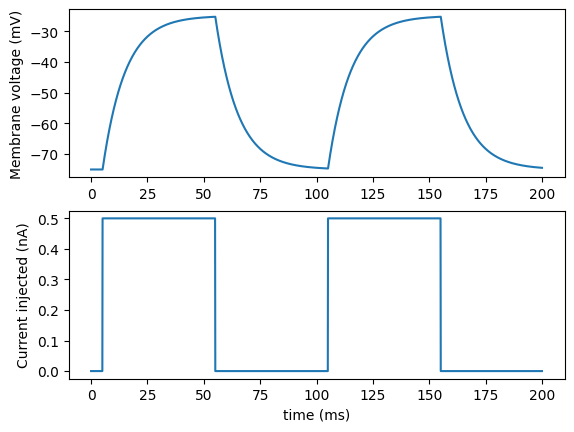

In [ ]:
# Define simulation parameters
dt = 0.1 # time step (ms)
tstop = 200 # duration of simulation (ms)
V0 = -75 # Initial voltage (mV)

# Define membrane parameters (checking units)
Rm = 100 # Membrane resistance (MOhm)
Cm = 0.1 # Membrane capacitance (nF)
Vr = -75 # Rest potential (mV)

# Define current stimulus
del1 = 5 # ms
dur1 = 50 # ms
amp1 = 0.5 # nA
isi = 50 # ms
dur2 = 50 # ms
amp2 = 0.5 # nA

t = np.arange(0,tstop+dt,dt) # time vector (ms)
I = gen2CurrentPulses(t,del1,dur1,amp1,isi,dur2,amp2) # your code goes here

# Simulate response
Vm,_ = simRCmemArbCurrent(dt,tstop,V0,Rm,Cm,Vr,I) # your code goes here

# Plot
fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(t,Vm)
ax.set_ylabel('Membrane voltage (mV)')
ax = fig.add_subplot(212)
ax.plot(t,I)
ax.set_xlabel('time (ms)')
ax.set_ylabel('Current injected (nA)');


Check that the output is as you expect based on your earlier simulations.

Now, let's try simulating a nueron with a faster time constant by lowering $R_{m}$ to $10 M\Omega$.

<span style="color:red"> ***Q5***: What biophysical changes might underly this difference? Think about the parameters that go into calculating the membrane resistance or properties of the membrane. Lots of possible answers for this would be acceptable. </span>

Membrane resistivity might be reduced by increasing the amount of free charge in the membrane, and resistance might change if a compartment becomes smaller.

With this neuron, let's apply shorter, more "synaptic input-like" pulses $5 \; ms$ in duration. What happens as we move the stimuli closer together (decrease the ISI)? Simulate and plot on the same axes the response as you decrease the isi from $10$ to $0 \; ms$ in $2 \; ms$ steps. Then in a separate figure, plot the peak polarization against the isi.

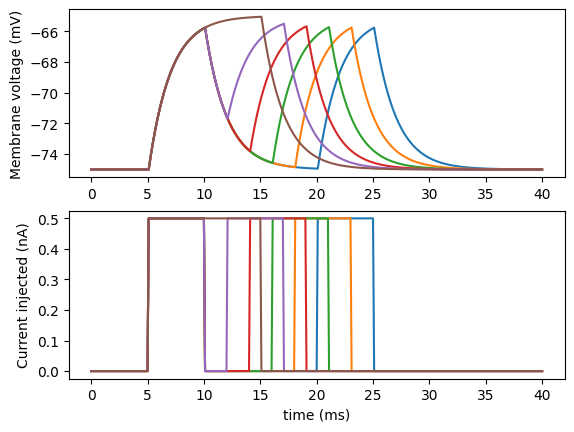

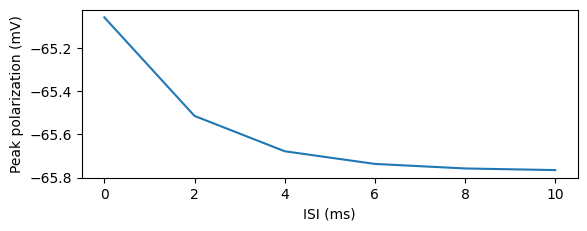

In [ ]:
# Define simulation parameters
dt = 0.1 # time step (ms)
tstop = 40 # duration of simulation (ms)
V0 = -75 # Initial voltage (mV)

# Define membrane parameters (checking units)
Rm = 20 # Membrane resistance (MOhm)
Cm = 0.1 # Membrane capacitance (nF)
Vr = -75 # Rest potential (mV)

# Define current stimuli
del1 = 5 # ms
dur1 = 5 # ms
amp1 = 0.5 # nA
dur2 = 5 # ms
amp2 = 0.5 # nA
isi_vec = np.arange(10,-1,-2) # define vector of ISI values - ms

t = np.arange(0,tstop+dt,dt) # time vector (ms)
Is = []
Vms = []
peak_pols = []
for isi in isi_vec:
    # Define current vector
    I = gen2CurrentPulses(t,del1,dur1,amp1,isi,dur2,amp2)
    Is.append(I)
    # Simulate response
    Vm,_ = simRCmemArbCurrent(dt,tstop,V0,Rm,Cm,Vr,I)
    temppeak_index = 0
    for i in np.arange(0,len(Vm),1):
        if i<len(Vm)-1 and Vm[i+1] > Vm[i]:
            temppeak_index = i+1
    Vms.append(Vm)
    peak_pols.append(Vm[temppeak_index])

# Plot responses
fig = plt.figure()
ax = fig.add_subplot(211)
for Vm in Vms:
    ax.plot(t,Vm)
ax.set_ylabel('Membrane voltage (mV)')
ax = fig.add_subplot(212)
for I,isi in zip(Is,isi_vec):
    ax.plot(t,I,label='ISI = {} ms'.format(isi))
ax.set_xlabel('time (ms)')
ax.set_ylabel('Current injected (nA)')

# Plot Peak polarization vs. ISI
fig = plt.figure()
ax = fig.add_subplot(212)
ax.plot(isi_vec,peak_pols)
ax.set_xlabel('ISI (ms)')
ax.set_ylabel('Peak polarization (mV)');

<span style="color:red"> ***Q6:*** Describe what you observed. What was required for the signals to summate? What happens if you increase the membrane time constant? </span>

As the time constant grows, there is less overall polarization in a given amount of time but signals can integrate over a longer time window.

Bonus exercise:

Try reproducing the plot I showed in class of peak polarization vs. input frequency. Below is the figure from the original paper by Carandini et al. (1996). You'll have to write a function to generate sinusoidal current inputs, simulate the response over a range of frequencies, and extract the peak change in $V_{m}$. There are a range of possible values for $R_{m}$ and $C_{m}$ that would match the data, since the important property is their product, the time constant.

<img src="https://raw.githubusercontent.com/CompModNervSystem/CompModNervSys-RCmodel/main/resources/Carandini1996_Fig8.png" alt_text="Fig8 from Carandini1996" width=300>

1. What was the approximate difficulty of the coding exercises for you (1-5, 1 being extremely easy, 5 being unreasonably difficult)? If you'd like, you can describe what aspects were easier/harder, but this is optional.

I'd put it around 3-4, mostly because I don't have much experience with applied programming and the array manipulation can be a lot to wrap my head around. I do think I'm getting the hang of it, though, so the largest outstanding obstacles are syntax (e.g., for accessing lists vs. tuples vs. arrays) and functions vs. methods (I think that's what they're called?), specifically how they're used to format plots.

2. Roughly how long did the exercises take? If it was significantly different between them, please give estimate for each exercise, (ex: "exercise 2 ~ 2 hrs, exercise 3 ~ 3 hrs, exercise 4 ~ 1 hr").

Around 4 hours each, though I think I got faster working through them - exercise 4 took less time than the others.